# HW 2

Use neural networks to the fit one year's worth of solar wind measurements.

In [2]:
# Import dependencies
from time import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch modules
import torch
from torch import nn
import torch.utils.data as Data

In [3]:
# Set plot parameters for entire notebook
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 80

In [4]:
# Check GPU availability
torch.cuda.is_available()

True

## 1 Data preprocessing

The CSV file should be in the same directory as this notebook. Otherwise, update the file_name path.

References:
* https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

### 1.1 Read CSV and define variable categories

The CSV file is stored in a public GitHub repository for convenience. Alternatively, reference a local file or upload the file into Colab's runtime.

In [5]:
url = 'https://raw.githubusercontent.com/vtd9/multilayer-perceptron/' + \
  'temp_space/Sample_Data_Set.csv'
df = pd.read_csv(url)

In [6]:
# Independent variables
indep_vars = ['Bx', 'By', 'Bz', 'Bmag_avg', 'Ni_avg', 'Vx', 'Vy', 'Vz', 'VSW', 
              'Vth_mag_Ion', 'Vth_para_Ion', 'Vth_perp_Ion', 'Ne', 'Ue', 
              'Te', 'Ti', 'Ti_para', 'Ti_perp']

# Derived variables: from independent variables using formulas
deriv_vars = ['VA', 'Beta', 'Beta_para', 'Beta_perp', 
              'Omega_i', 'omega_pi', 'omega_pe', 'rho_i', 'rho_s', 'rho_c', 
              'd_i', 'd_e', 'sigma_i', 'Lperp', 'lambda_d']

# Dependent variable: target
dep_var = ['k_brk']

# Check that the number of variables in each category are as expected
print('Independent: {}, derived: {}, dependent: {}'.format(
    len(indep_vars), len(deriv_vars), len(dep_var)))

# Convert Pandas dataframes to PyTorch tensors by column names
indep = torch.tensor(df[indep_vars].values)
deriv = torch.tensor(df[deriv_vars].values)
dep = torch.tensor(df[dep_var].values)

# Check whether tensors were initialized on the GPU
indep.is_cuda, deriv.is_cuda, dep.is_cuda

Independent: 18, derived: 15, dependent: 1


(False, False, False)

### 1.2 Visualize the input data

In [7]:
def plot_many(xs, y, xs_names, num_cols=6, title='', subfont=10,
              size=(10, 8)):
  '''
  Plot multiple variables against a single one.
  '''
  num_plots = len(xs_names)
  num_rows = int(num_plots / num_cols) + 1
  plt.subplots(figsize=size)

  # For each variable in x
  for i in range(num_plots):
      plt.subplot(num_rows, num_cols, i + 1)
      plt.plot(xs[:, i].cpu(), y.cpu(), '.', alpha=0.5)
      plt.title(xs_names[i], y=1.15, fontsize=subfont)
      plt.ticklabel_format(style='sci', scilimits=(-3, 4), axis='x')
  plt.suptitle(title)
  plt.tight_layout(rect=[0, 0.05, 1, 0.96])

In [8]:
#plot_many(indep, dep[:, 0], indep_vars, title='Independent variables vs. $k_{brk}$')

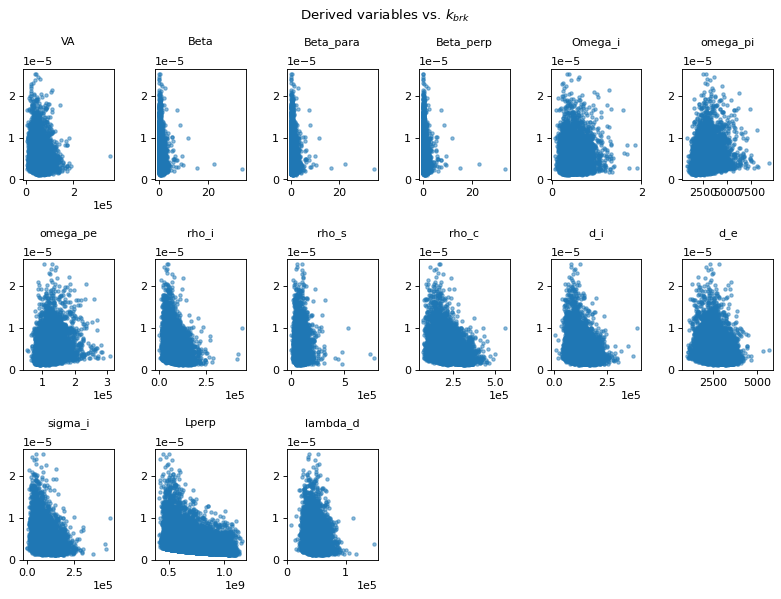

In [9]:
plot_many(deriv, dep[:, 0], deriv_vars, title='Derived variables vs. $k_{brk}$')

### 1.3 Prepare for feeding into network

In [10]:
# Normalize the inputs
indep = torch.nn.functional.normalize(indep, dim=0)
deriv = torch.nn.functional.normalize(deriv, dim=0)

# Create datasets
indep_set = Data.TensorDataset(indep, dep)
deriv_set = Data.TensorDataset(deriv, dep)

# Decide on training, validation, and testing splits
train_size = int(0.8 * len(df))
valid_size = int(0.1 * len(df))
test_size = len(df) - (train_size + valid_size)
splits = [train_size, valid_size, test_size]

print('Training, validation, & testing split:', splits)

# Split the data for both indep-dep pairs & derived-dep pairs
train_indep, valid_indep, test_indep = Data.random_split(indep_set, splits)
train_deriv, valid_deriv, test_deriv = Data.random_split(deriv_set, splits)

# Define dataloaders
batch_size = 64
n_work = 2
train_loader_indep = Data.DataLoader(dataset=train_indep, batch_size=batch_size, 
                                     shuffle=True, num_workers=n_work)
valid_loader_indep = Data.DataLoader(dataset=valid_indep, batch_size=batch_size,
                                     shuffle=True, num_workers=n_work)
test_loader_indep = Data.DataLoader(dataset=test_indep, batch_size=batch_size, 
                                    shuffle=True, num_workers=n_work)
train_loader_deriv= Data.DataLoader(dataset=train_indep, batch_size=batch_size, 
                                    shuffle=True, num_workers=n_work)
valid_loader_deriv = Data.DataLoader(dataset=valid_indep, batch_size=batch_size, 
                                     shuffle=True, num_workers=n_work)
test_loader_deriv = Data.DataLoader(dataset=test_deriv, batch_size=batch_size, 
                                    shuffle=True, num_workers=n_work)

Training, validation, & testing split: [5626, 703, 704]


## 2 Define classes and functions

References:
* https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html
* https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

### 2.1 `Net` class

Define a general template to easily create models.

Regarding the order of activation, batch normalization, and dropout, and whether dropout is necessary when the model has batch normalization, different people seem to have different opinions: 
* https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout. 
* https://www.kaggle.com/code/ryanholbrook/dropout-and-batch-normalization/tutorial

Here, apply batch normalization after activation and dropout after normalization.

In [11]:
class Net(nn.Module): 
  def __init__(self, n_in, hiddens, n_out, batch_norm=True, p_dropout=0.5):
    super(Net, self).__init__()
    layers = []
    
    # Define hidden layer(s)
    hiddens_list = [n_in, ] + list(hiddens)
    for i, hidden in enumerate(hiddens_list[:-1]):
        curr_hidden = [nn.Linear(hidden, hiddens_list[i+1]),]

        # Add activation (ReLU)
        curr_hidden.append(nn.ReLU())

        # If set, add batch normalization
        if batch_norm:
            curr_hidden.append(nn.BatchNorm1d(hiddens_list[i+1]))

        # If set, add dropout
        if p_dropout is not None:
            curr_hidden.append(nn.Dropout(p_dropout))    
            
        layers += curr_hidden 

    # Define output layer
    layers.append(nn.Linear(hiddens[-1], n_out))

    # Define entire stack
    self.stack = nn.Sequential(*layers)
      
  def forward(self, x):
      logits = self.stack(x)
      return logits

# Initialize parameters
def init_parameters(m):
  if isinstance(m, nn.Linear):
      # weights: Kaiming initialization
      nn.init.kaiming_normal_(m.weight)

      # biases: set to 0, as discussed in class
      m.bias.data.fill_(0.0) # Set bias to 0

In [12]:
def mult_models(n_in, hidden_dims, n_out, lr, momentum=0.5,
                decay=1e-5, opt_sgd=True):
  '''
  Create multiple models using one or more configurations for the hidden 
  layers. Return as a dictionary with keys based on the number of neurons in
  the hidden layers as well the model-specific add-ons or lack thereof.
  '''
  models_dict = {}
  for dim in hidden_dims:  
    # Batch norm & dropout of 50%
    model = Net(n_in, dim, n_out)
    model.apply(init_parameters)
    if opt_sgd:
      models_dict[str(dim) + ' drop 50%'] = {
          'model': model,
          'opt' : torch.optim.SGD(model.parameters(), lr=lr,
                                  momentum=momentum, weight_decay=decay)}
    else:
          models_dict[str(dim) + ' drop 50%'] = {
          'model': model,
          'opt': torch.optim.Adam(model.parameters(), 
                                  lr=lr, weight_decay=decay)}

    # Batch norm & dropout of 25%
    model = Net(n_in, dim, n_out, p_dropout=0.25)
    model.apply(init_parameters)
    if opt_sgd:
      models_dict[str(dim) + ' drop 25%'] = {
          'model': model,
          'opt' : torch.optim.SGD(model.parameters(), lr=lr,
                                  momentum=momentum, weight_decay=decay)}
    else:
          models_dict[str(dim) + ' drop 25%'] = {
          'model': model,
          'opt': torch.optim.Adam(model.parameters(), 
                                  lr=lr, weight_decay=decay)}

    # Batch norm, but no dropout
    model = Net(n_in, dim, n_out, p_dropout=None)
    model.apply(init_parameters)
    if opt_sgd:
      models_dict[str(dim) + ' no drop'] = {
          'model': model,
          'opt' : torch.optim.SGD(model.parameters(), lr=lr,
                                  momentum=momentum, weight_decay=decay)}
    else:
          models_dict[str(dim) + ' no drop'] = {
          'model': model,
          'opt': torch.optim.Adam(model.parameters(), lr=lr)}
    
    # No norm, no dropout
    model = Net(n_in, dim, n_out, batch_norm=False, p_dropout=None)
    model.apply(init_parameters)
    if opt_sgd:
      models_dict[str(dim) + ' no norm'] = {
          'model': model,
          'opt' : torch.optim.SGD(model.parameters(), lr=lr,
                                  momentum=momentum, weight_decay=decay)}
    else:
          models_dict[str(dim) + ' no norm'] = {
          'model': model,
          'opt': torch.optim.Adam(model.parameters(), lr=lr)}

  return models_dict

### 2.2 Functions for training, testing, and plotting

Train & test functions for one loop through the datasets (aka one epoch) as well as loop over multiple epochs.

Option to configure a GPU with PyTorch. References: 

* https://pytorch.org/docs/stable/notes/cuda.html
* https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel

In [33]:
def train_loop(loader, model, loss_fun, optimizer, device='cpu'):
  '''
  Train a model for one epoch - i.e., one pass through the training data set.
  '''
  train_loss = 0.0
  model = model.double()
  model = model.to(device)

  # For each batch
  for X, y in loader:
    X = X.to(device)
    y = y.to(device)

    # Forward pass
    prediction = model(X)
    loss = loss_fun(prediction, y) # compute loss
    train_loss += loss.item() # assume reduction over batch

    # Backward pass
    optimizer.zero_grad() # clear gradients for this loop
    loss.backward() # compute gradients
    optimizer.step() # apply gradients
  
  # Average loss in the epoch loop
  return train_loss/len(loader)
    
def test_loop(loader, model, loss_fun, device='cpu', return_y=False):
  '''
  Test a model through one pass through a validation/test data set.
  '''
  test_loss = 0.0
  model = model.double()
  model = model.to(device)

  # No backprop during validation/testing
  with torch.no_grad():
    for X, y in loader:
      X = X.to(device)
      y = y.to(device)
      prediction = model(X)
      test_loss += loss_fun(prediction, y).item()

  # If requested, return last prediction & the corresponding labels, too
  if return_y: 
    return prediction, y, test_loss/len(loader)
  else: # Else, return average loss in the loop
    return test_loss/len(loader)

def train_epochs(train_loader, valid_loader, model, loss_fun, optimizer, 
    epochs, verbose=False, use_gpu=False):
    '''
    Train and validate a model over multiple epochs.
    '''
    train_losses = np.empty(epochs)
    test_losses = np.empty(epochs)

    if use_gpu:
      device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    else:
      device = 'cpu'

    # For each epoch
    for epoch in range(epochs):
        train_losses[epoch] = train_loop(train_loader, model, 
            loss_fun, optimizer=optimizer, device=device)
        test_losses[epoch] = test_loop(valid_loader, model, 
                                       loss_fun, device=device)
    
        if verbose:
            print('epoch: {}\ttraining loss: {:.3e}'
            '\tvalidation loss: {:.3e}'.format(
                epoch, train_losses[epoch], test_losses[epoch]))
    
    return train_losses, test_losses

In [34]:
def train_mult_models(models, train_loader, valid_loader, loss_fun,
                      epochs=25, verbose=False, use_gpu=False):
  '''
  Train (and validate) multiple models in sequence. Assume `models` is a
  dictionary produced by the above function `mult_models`.
  '''
  fun_start = time()
  for key, value in models.items():
    start = time()
    model = value['model']
    opt = value['opt']
    models[key]['result'] = train_epochs(
        train_loader, valid_loader, model, 
        loss_fun=loss_fun, optimizer=opt, epochs=epochs, verbose=verbose,
        use_gpu=use_gpu)
    print('{0: <25}'.format(key), '{:.1f}s'.format(time() - start))
  print('Total time: {:.1f}s'.format(time() - fun_start))

def get_ending_losses(models, get_valid=True):
  '''
  Print out multiple models' performance after the last loop.
  '''
  for key, value in models.items():
    if get_valid:
      print('{0: <25}'.format(key), 
            'validation loss: {:.3e}'.format(value['result'][1][-1]))
    else:
      print('{0: <25}'.format(key), 
            'training loss: {:.3e}'.format(value['result'][0][-1]))

def plot_mult_models(models, xlabel='Epoch', ylabel='Mean squared error', 
                     yscale='log', title='', train_index=0, valid_index=1,
                     result_key='result', train_append=' training', 
                     valid_append=' validation', train_style='-', 
                     valid_style='--', bottom_legend=True):
  '''
  Plot multiple models on the same graph, each with its own training and 
  validation results.
  '''
  colors=itertools.cycle(('tab:blue', 'tab:orange', 'tab:green', 'tab:red',
                          'tab:purple', 'tab:pink','b', 'y', 'c', 'm', 'k',
                          'tab:gray', 'tab:olive'))
  for key, value in models.items():
    color = next(colors)
    epochs = value[result_key][0].shape[0]
    # Plot training performance
    plt.plot(np.arange(epochs), 
        value[result_key][train_index], train_style, 
        color=color, label=key+train_append)
    
    # Plot validation performance
    plt.plot(np.arange(epochs), 
        value[result_key][valid_index], valid_style, 
        color=color, label=key+valid_append)
  plt.title(title)
  plt.yscale(yscale)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  if bottom_legend:
    plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, -0.1))
  else:
     plt.legend(ncol=2)

## 3 Independent &rarr; dependent variables

Create a model to relate the independent variables to the dependent variable.

In [15]:
# Standard mean squared error loss function
mse = nn.MSELoss(reduction='mean') # default reduction

### 3.1 Three hidden layers

In [51]:
# Create container to store models, optimizers, & results in
models3 = mult_models(len(indep_vars), [(16, 8, 4), (8, 4, 2)], 1, lr=0.01)

# Train
train_mult_models(models3, train_loader_indep, valid_loader_indep, mse, 25)

(16, 8, 4) drop 50%       15.4s
(16, 8, 4) drop 25%       15.2s
(16, 8, 4) no drop        15.0s
(16, 8, 4) no norm        13.4s
(8, 4, 2) drop 50%        15.3s
(8, 4, 2) drop 25%        15.5s
(8, 4, 2) no drop         15.0s
(8, 4, 2) no norm         13.6s
Total time: 118.4s


In [52]:
# See actual losses from validation
get_ending_losses(models3)

(16, 8, 4) drop 50%       validation loss: 8.836e-12
(16, 8, 4) drop 25%       validation loss: 8.614e-12
(16, 8, 4) no drop        validation loss: 3.207e-04
(16, 8, 4) no norm        validation loss: 2.268e-06
(8, 4, 2) drop 50%        validation loss: 8.719e-12
(8, 4, 2) drop 25%        validation loss: 8.726e-12
(8, 4, 2) no drop         validation loss: 3.370e-05
(8, 4, 2) no norm         validation loss: 2.461e-07


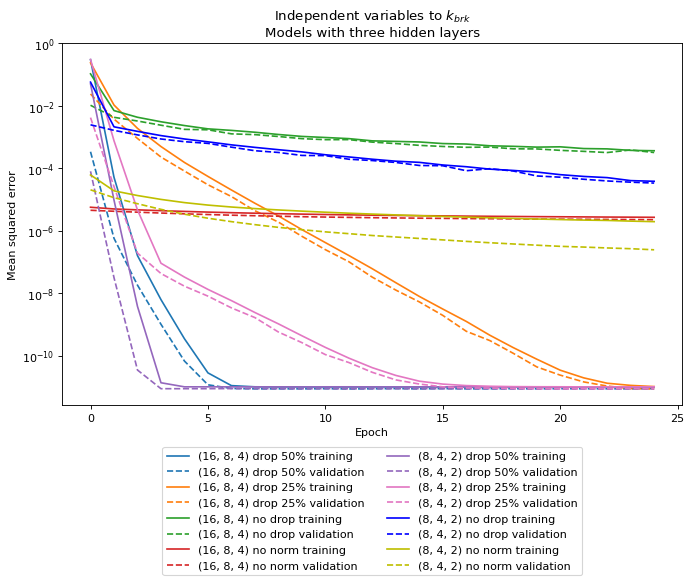

In [53]:
# Plot on log scale
plot_mult_models(models3,
                 title='Independent variables to $k_{brk}$'
                 + '\nModels with three hidden layers')

(8e-12, 1.2e-11)

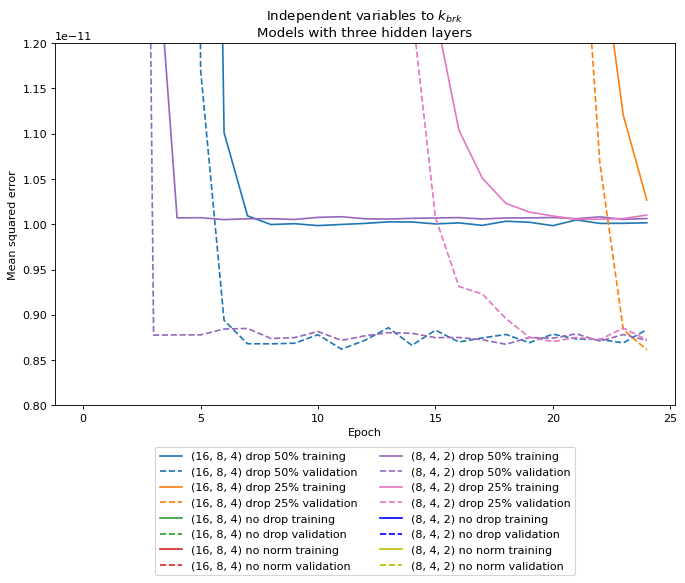

In [56]:
# Plot on linear scale
plot_mult_models(models3, yscale='linear',
                 title='Independent variables to $k_{brk}$'
                 + '\nModels with three hidden layers')
plt.ylim(8e-12, 1.2e-11)

#### 3.1.1 ADAM

Experiment with another optimization algorithm, ADAM, instead of stochastic gradient descent (SGD).

In [58]:
models3a = mult_models(len(indep_vars), [(16, 8, 4), (8, 4, 2)], 1, 0.01, opt_sgd=False)
train_mult_models(models3a, train_loader_indep, valid_loader_indep, mse, epochs=25)

(16, 8, 4) drop 50%       19.6s
(16, 8, 4) drop 25%       17.6s
(16, 8, 4) no drop        17.1s
(16, 8, 4) no norm        15.5s
(8, 4, 2) drop 50%        17.6s
(8, 4, 2) drop 25%        17.7s
(8, 4, 2) no drop         18.2s
(8, 4, 2) no norm         18.2s
Total time: 141.6s


In [59]:
get_ending_losses(models3), print('\nCompare to:'), get_ending_losses(models3a)

(16, 8, 4) drop 50%       validation loss: 8.836e-12
(16, 8, 4) drop 25%       validation loss: 8.614e-12
(16, 8, 4) no drop        validation loss: 3.207e-04
(16, 8, 4) no norm        validation loss: 2.268e-06
(8, 4, 2) drop 50%        validation loss: 8.719e-12
(8, 4, 2) drop 25%        validation loss: 8.726e-12
(8, 4, 2) no drop         validation loss: 3.370e-05
(8, 4, 2) no norm         validation loss: 2.461e-07

Compare to:
(16, 8, 4) drop 50%       validation loss: 8.761e-12
(16, 8, 4) drop 25%       validation loss: 8.677e-12
(16, 8, 4) no drop        validation loss: 1.996e-05
(16, 8, 4) no norm        validation loss: 3.191e-09
(8, 4, 2) drop 50%        validation loss: 9.023e-12
(8, 4, 2) drop 25%        validation loss: 9.037e-12
(8, 4, 2) no drop         validation loss: 1.015e-07
(8, 4, 2) no norm         validation loss: 4.639e-11


(None, None, None)

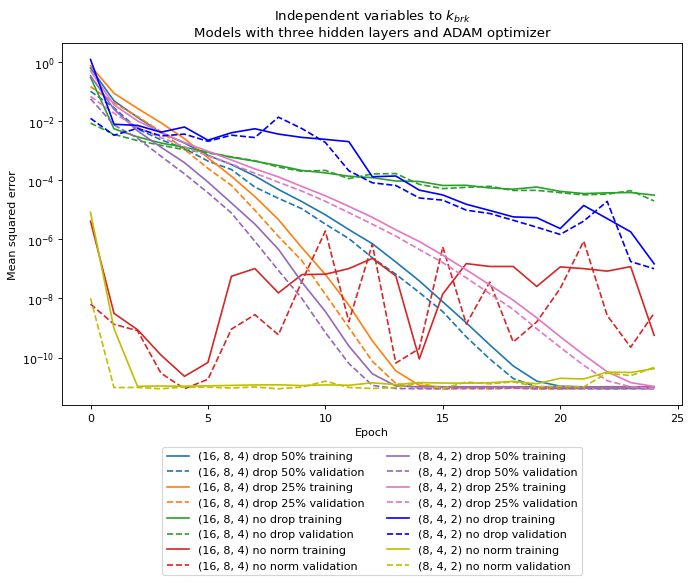

In [60]:
plot_mult_models(models3a, 
                 title='Independent variables to $k_{brk}$'
                 + '\nModels with three hidden layers and ADAM optimizer')

### 3.2 Four hidden layers

In [74]:
models4 = mult_models(len(indep_vars), [(24, 16, 8, 4), (12, 8, 4, 2)], 1, 0.01)
train_mult_models(models4, train_loader_indep, valid_loader_indep, mse, 
                  epochs=25)

(24, 16, 8, 4) drop 50%   19.7s
(24, 16, 8, 4) drop 25%   17.9s
(24, 16, 8, 4) no drop    17.4s
(24, 16, 8, 4) no norm    16.2s
(12, 8, 4, 2) drop 50%    18.2s
(12, 8, 4, 2) drop 25%    18.3s
(12, 8, 4, 2) no drop     17.6s
(12, 8, 4, 2) no norm     16.5s
Total time: 141.9s


In [78]:
get_ending_losses(models4)

(24, 16, 8, 4) drop 50%   validation loss: 8.664e-12
(24, 16, 8, 4) drop 25%   validation loss: 8.623e-12
(24, 16, 8, 4) no drop    validation loss: 1.479e-03
(24, 16, 8, 4) no norm    validation loss: 2.661e-08
(12, 8, 4, 2) drop 50%    validation loss: 8.747e-12
(12, 8, 4, 2) drop 25%    validation loss: 8.612e-12
(12, 8, 4, 2) no drop     validation loss: 9.184e-12
(12, 8, 4, 2) no norm     validation loss: 1.357e-08


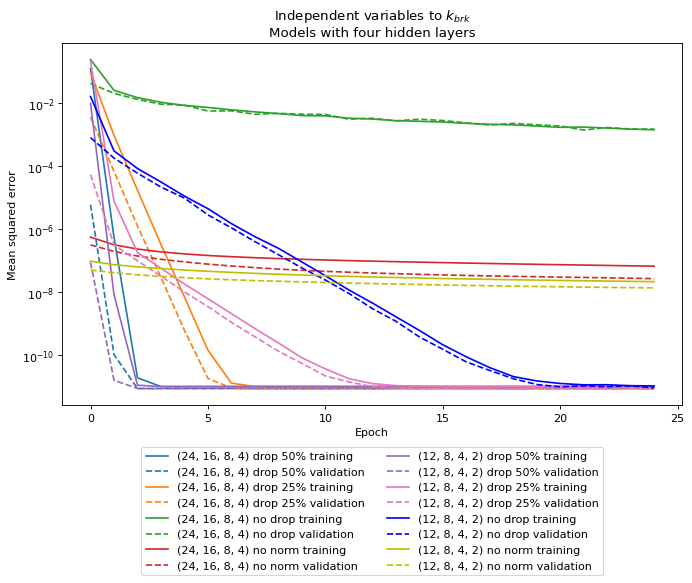

In [79]:
plot_mult_models(models4,
                 title='Independent variables to $k_{brk}$'
                 + '\nModels with four hidden layers')

(8e-12, 1.3e-11)

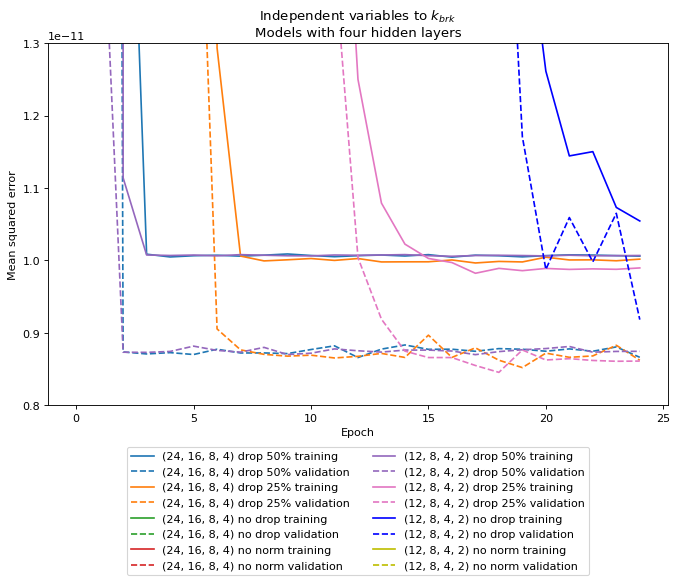

In [80]:
plot_mult_models(models4, yscale='linear',
                 title='Independent variables to $k_{brk}$'
                 + '\nModels with four hidden layers')
plt.ylim(8e-12, 1.3e-11)

### 3.3 Five hidden layers

In [81]:
# Create container to store models, optimizers, & results in
models5 = mult_models(len(indep_vars), [(24, 20, 16, 8, 4), (16, 12, 8, 4, 2)], 
                      1, 0.01)

# Train
train_mult_models(models5, train_loader_indep, valid_loader_indep, mse, 
                  epochs=25)

(24, 20, 16, 8, 4) drop 50% 19.5s
(24, 20, 16, 8, 4) drop 25% 19.8s
(24, 20, 16, 8, 4) no drop 21.7s
(24, 20, 16, 8, 4) no norm 24.3s
(16, 12, 8, 4, 2) drop 50% 20.9s
(16, 12, 8, 4, 2) drop 25% 19.6s
(16, 12, 8, 4, 2) no drop 18.9s
(16, 12, 8, 4, 2) no norm 17.2s
Total time: 161.9s


In [82]:
# See actual losses from validation
get_ending_losses(models5)

(24, 20, 16, 8, 4) drop 50% validation loss: 8.783e-12
(24, 20, 16, 8, 4) drop 25% validation loss: 3.523e-11
(24, 20, 16, 8, 4) no drop validation loss: 8.596e-07
(24, 20, 16, 8, 4) no norm validation loss: 1.413e-06
(16, 12, 8, 4, 2) drop 50% validation loss: 8.719e-12
(16, 12, 8, 4, 2) drop 25% validation loss: 8.719e-12
(16, 12, 8, 4, 2) no drop validation loss: 8.385e-12
(16, 12, 8, 4, 2) no norm validation loss: 1.529e-09


In [ ]:
plot_mult_models(models5,
                 title='Independent variables to $k_{brk}$'
                 + '\nModels with five hidden layers and SGD optimizer')

NameError: ignored

(7e-12, 1.1e-11)

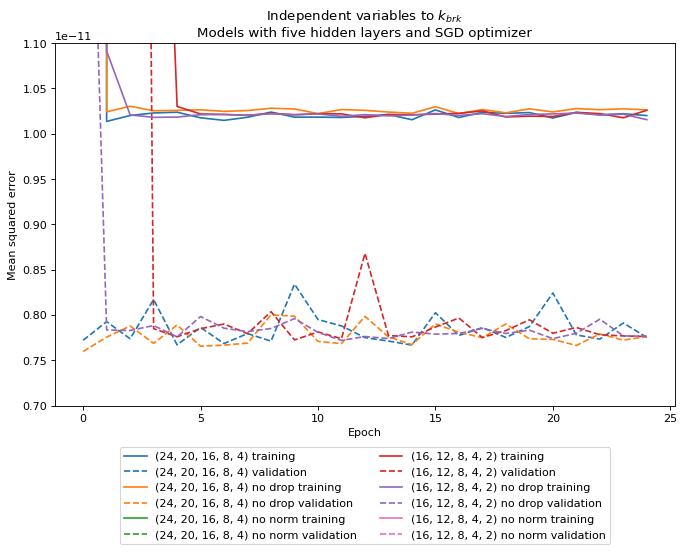

In [ ]:
plot_mult_models(models5, yscale='linear',
                 title='Independent variables to $k_{brk}$'
                 + '\nModels with five hidden layers and SGD optimizer')
plt.ylim(7e-12, 1.1e-11)

### 3.4 Test dataset

Report chosen model's performance with test set

In [ ]:
model = None
test_loss = test_loop(test_loader_indep, model, mse)
print('{:.3e}'.format(test_loss))

TypeError: ignored

## 4 Derived &rarr; dependent variables

## 5 Derivatives